# Notebook Versions

- Version 1 (10/31/2024)
   * EDA
   * Baseline modeling 1.0


- Version 2 (10/31/2024)
   * Fixing submission bug. Rounding prediction labels.
 

- Version 4 (10/31/2024)
   * Fixing rounding issues.


- Version 5 (11/03/2024)
   * Baseline modeling 2.0
      
# Loading Libraries

In [1]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import gc

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

import re

from functools import partial
from scipy.stats import kurtosis, skew, gmean, mode

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, FunctionTransformer, PowerTransformer, PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import KNNImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, cross_val_predict, RepeatedKFold
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss, f1_score, r2_score, accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Ridge, RidgeCV
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC, LinearSVR

from category_encoders import TargetEncoder

import ydf
from ydf import GradientBoostedTreesLearner

import xgboost as xgb

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

from sklearn.neural_network import MLPClassifier

import optuna

# Reading Data 

In [2]:
%%time
train = pd.read_csv('../input/playground-series-s4e11/train.csv', index_col=0)
test = pd.read_csv('../input/playground-series-s4e11/test.csv', index_col=0)

print('The dimension of the train dataset is:', train.shape)
print('The dimension of the test dataset is:', test.shape)

The dimension of the train dataset is: (140700, 19)
The dimension of the test dataset is: (93800, 18)
CPU times: user 787 ms, sys: 145 ms, total: 932 ms
Wall time: 1.15 s


In [3]:
train.head()

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
id,,,,,,,,,,,,,,,,,,,
0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [4]:
test.head()

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
id,,,,,,,,,,,,,,,,,,
140700,Shivam,Male,53.0,Visakhapatnam,Working Professional,Judge,NaN,2.0,NaN,NaN,5.0,Less than 5 hours,Moderate,LLB,No,9.0,3.0,Yes
140701,Sanya,Female,58.0,Kolkata,Working Professional,Educational Consultant,NaN,2.0,NaN,NaN,4.0,Less than 5 hours,Moderate,B.Ed,No,6.0,4.0,No
140702,Yash,Male,53.0,Jaipur,Working Professional,Teacher,NaN,4.0,NaN,NaN,1.0,7-8 hours,Moderate,B.Arch,Yes,12.0,4.0,No
140703,Nalini,Female,23.0,Rajkot,Student,NaN,5.0,NaN,6.84,1.0,NaN,More than 8 hours,Moderate,BSc,Yes,10.0,4.0,No
140704,Shaurya,Male,47.0,Kalyan,Working Professional,Teacher,NaN,5.0,NaN,NaN,5.0,7-8 hours,Moderate,BCA,Yes,3.0,4.0,No


First, let's check for missing values in the `train` and `test` data frames.

In [5]:
print('--- Percentage of Missing Values in Train ---\n')
print(100*train.isnull().sum() / train.shape[0])
print('\n')
print('--- Percentage of Missing Values in Test ---\n')
print(100*test.isnull().sum() / test.shape[0])

--- Percentage of Missing Values in Train ---

Name                                      0.000000
Gender                                    0.000000
Age                                       0.000000
City                                      0.000000
Working Professional or Student           0.000000
Profession                               26.034115
Academic Pressure                        80.172708
Work Pressure                            19.842217
CGPA                                     80.171997
Study Satisfaction                       80.172708
Job Satisfaction                         19.836532
Sleep Duration                            0.000000
Dietary Habits                            0.002843
Degree                                    0.001421
Have you ever had suicidal thoughts ?     0.000000
Work/Study Hours                          0.000000
Financial Stress                          0.002843
Family History of Mental Illness          0.000000
Depression                         

From the above tables, there are some features that have a significant proportion of missing values. Next, we check for potential duplicates.

In [6]:
print(f"There are {sum(train.duplicated())} duplicated rows in the train data frame.")

print("\n")
print(f"After dropping the Depression column, there are {sum(train.drop(columns=['Depression'], axis=1).duplicated())} duplicated rows in the train data frame.")

print("\n")
print(f"There are {sum(test.duplicated())} duplicated rows in the test data frame.")

There are 0 duplicated rows in the train data frame.


After dropping the Depression column, there are 0 duplicated rows in the train data frame.


There are 0 duplicated rows in the test data frame.


Finally, we check if there are any observations that appear in both the `train` and `test` data frames.

In [7]:
temp_train = train.drop(columns=['Depression'], axis=1)
temp_test = test

inner_join = pd.merge(temp_train, temp_test)
print(f"There are {inner_join.shape[0]} observations that appear in both the train and test data frames")

There are 0 observations that appear in both the train and test data frames


# Data Exploration

First, we start by exploring the distribution of `Depression`.

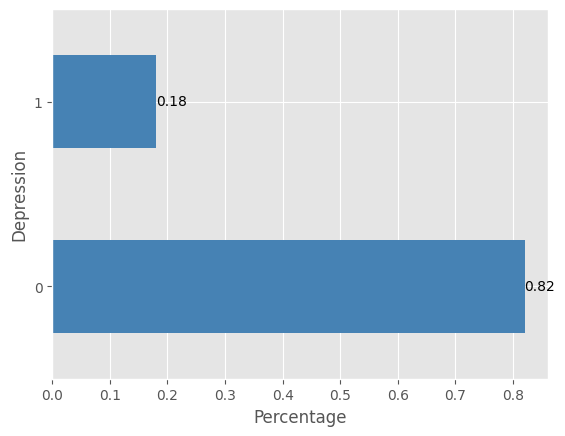

In [8]:
ax = round(train['Depression'].value_counts(normalize=True), 2).plot(kind='barh', color='steelblue')
ax.bar_label(ax.containers[0], label_type='edge')
ax.margins(y=0.1)
plt.xlabel('Percentage');

From the above chart, we see that this is an imbalanced dataset. `Depression=1` is the less frequent label. Next, we explore the relationships between the input features and `Depression`.


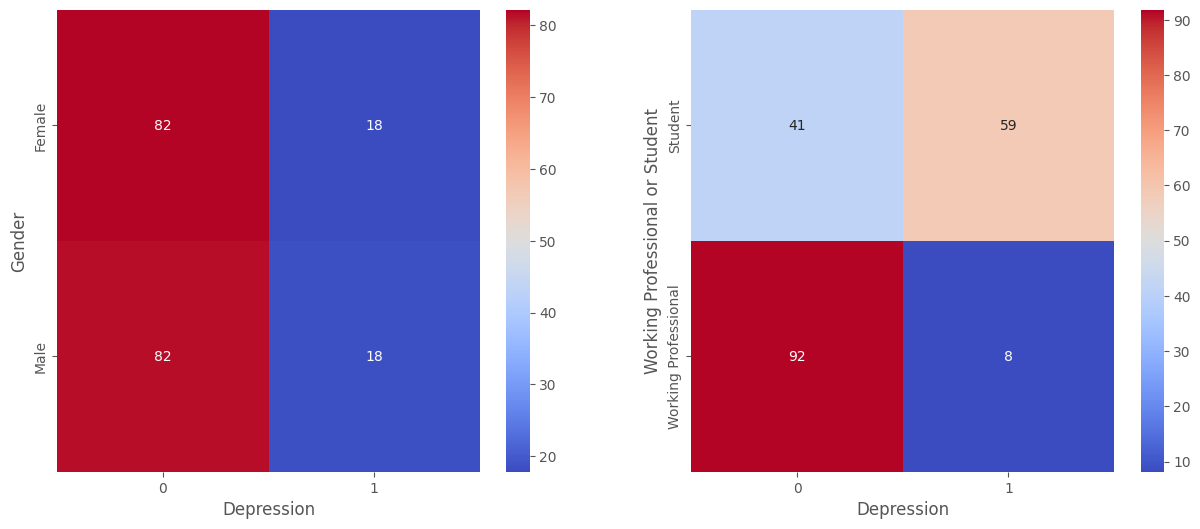

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

cmap = sns.color_palette("coolwarm", as_cmap=True)

sns.heatmap(data=round(100*pd.crosstab(train['Gender'], train['Depression'], normalize=0), 2), annot=True, cmap=cmap, fmt='.0f', ax=axes[0])
sns.heatmap(data=round(100*pd.crosstab(train['Working Professional or Student'], train['Depression'], normalize=0), 2), annot=True, cmap=cmap, fmt='.0f', ax=axes[1]);

From the above charts, we observe the following:

- `Gender` doesn't seem to be related to `Depression`.
- `Students` are more likely to be depressed when compared to `Working Professionals`.

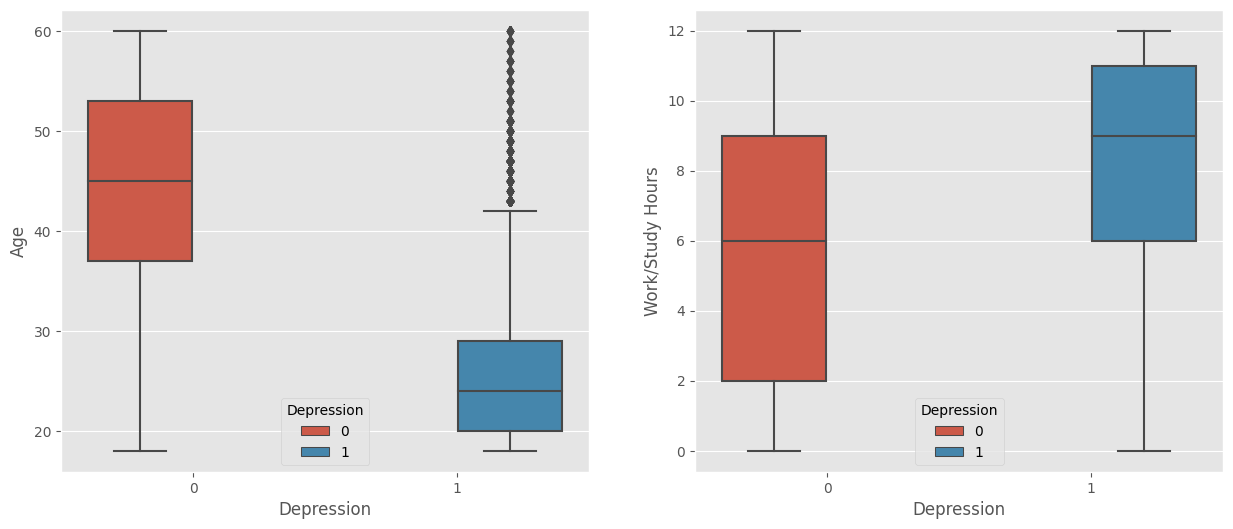

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.boxplot(x='Depression', y='Age', data=train, hue='Depression', ax=axes[0])
sns.boxplot(x='Depression', y='Work/Study Hours', data=train, hue='Depression', ax=axes[1]);

From the above charts, we observe the following:

- When compared the medians of the age of the groups, the median age of the depressed group is smaller.
- When compared the medians of the work/study hours, the median work/study hours of the depressed group is higher.
- Notice that these charts agree with the insights from the heatmaps.

# Baseline Modeling 1.0

In this section, we train some models without preprocessing the data.

In [11]:
%%time
X = train.drop(columns=['Name', 'Depression'], axis=1)
y = train['Depression']

test = test.drop(columns=['Name'], axis=1)

cat_cols = ['Gender',
            'City',
            'Working Professional or Student',
            'Profession',
            'Sleep Duration',
            'Dietary Habits',
            'Degree',
            'Have you ever had suicidal thoughts ?',
            'Family History of Mental Illness']

for col in cat_cols:
    X[col] = X[col].astype('str')
    test[col] = test[col].astype('str')

skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=42)

CPU times: user 103 ms, sys: 9.03 ms, total: 112 ms
Wall time: 110 ms


In [12]:
%%time
cat_params = {'loss_function': 'Logloss',
              'iterations': 300,
              'task_type': 'CPU'}

test_pool = Pool(data=test, cat_features=cat_cols)

scores, cat_oof_preds, cat_test_preds = list(), list(), list()
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    
    print(f"------------ Working on Fold {i} ------------")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model_pool = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    eval_pool = Pool(data=X_test, label=y_test, cat_features=cat_cols)
            
    cat_md = CatBoostClassifier(**cat_params).fit(model_pool, eval_set=eval_pool, verbose=0)
    preds = cat_md.predict(eval_pool)
    
    oof_preds = pd.DataFrame()
    oof_preds['y'] = y_test.values
    oof_preds['cat_preds'] = preds
    oof_preds['fold'] = i
    cat_oof_preds.append(oof_preds)
    
    score = accuracy_score(y_test, preds)
    print(f"The oof accuracy score is {score}")
    scores.append(score)
    
    test_preds = pd.DataFrame()
    test_preds['cat_preds'] = cat_md.predict(test_pool)
    test_preds['fold'] = i
    cat_test_preds.append(test_preds)

cat_oof_score = np.mean(scores)  
cat_std = np.std(scores)
print(f"The 10-fold average oof ROC-AUC score of the CatBoost model is {cat_oof_score}")
print(f"The 10-fold std oof ROC-AUC score of the CatBoost model is {cat_std}")

------------ Working on Fold 0 ------------
The oof accuracy score is 0.9383084577114428
------------ Working on Fold 1 ------------
The oof accuracy score is 0.9406538734896944
------------ Working on Fold 2 ------------
The oof accuracy score is 0.9378820184790334
------------ Working on Fold 3 ------------
The oof accuracy score is 0.9384506041222459
------------ Working on Fold 4 ------------
The oof accuracy score is 0.9404406538734897
------------ Working on Fold 5 ------------
The oof accuracy score is 0.9398009950248756
------------ Working on Fold 6 ------------
The oof accuracy score is 0.9400142146410803
------------ Working on Fold 7 ------------
The oof accuracy score is 0.9427860696517413
------------ Working on Fold 8 ------------
The oof accuracy score is 0.9393034825870646
------------ Working on Fold 9 ------------
The oof accuracy score is 0.9398009950248756
The 10-fold average oof ROC-AUC score of the CatBoost model is 0.9397441364605543
The 10-fold std oof ROC-AUC 

In [13]:
out = pd.concat(cat_test_preds)
final_preds = []
for i in range(0, 10):
    dat = out[out['fold']==i].reset_index(drop=True)
    final_preds.append(dat['cat_preds'].values)

In [14]:
%%time
submission = pd.read_csv('../input/playground-series-s4e11/sample_submission.csv')
submission['Depression'] = np.where(np.mean(final_preds, axis=0)==0.0, 0, 1)
submission.head()

CPU times: user 27.2 ms, sys: 7.95 ms, total: 35.2 ms
Wall time: 64.7 ms


,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0


In [15]:
submission.to_csv('baseline_sub_1.csv', index=False)

# Baseline Modeling 2.0

In this section, we continue exploring `CatBoost` as the main model. The big difference between this section and the previous one are:

- `Name` is included as one of the input variables.
- All of the features are treated as categorical features.

In [16]:
%%time
train = pd.read_csv('../input/playground-series-s4e11/train.csv', index_col=0)
test = pd.read_csv('../input/playground-series-s4e11/test.csv', index_col=0)

cat_cols = ['Name',
            'Gender',
            'City',
            'Working Professional or Student',
            'Profession',
            'Sleep Duration',
            'Dietary Habits',
            'Degree',
            'Have you ever had suicidal thoughts ?',
            'Family History of Mental Illness']

for col in cat_cols:
    train[col] = train[col].astype('str')
    test[col] = test[col].astype('str')

X = train.drop(columns=['Depression'], axis=1)
y = train['Depression']

test_pool = Pool(data=test, cat_features=cat_cols)

skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=42)

CPU times: user 1.1 s, sys: 95.9 ms, total: 1.2 s
Wall time: 1.14 s


Next, we run 10-fold cross-validation experiment as follows:

In [17]:
%%time
cat_params = {'loss_function': 'Logloss', 'iterations': 421, 'depth': 5, 'task_type': 'CPU'}

scores, cat_oof_preds, cat_test_preds = list(), list(), list()
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    
    print(f"------------ Working on Fold {i} ------------")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model_pool = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    eval_pool = Pool(data=X_test, label=y_test, cat_features=cat_cols)
            
    cat_md = CatBoostClassifier(**cat_params).fit(model_pool, eval_set=eval_pool, verbose=0)
    preds = cat_md.predict(eval_pool)
    
    oof_preds = pd.DataFrame()
    oof_preds['y'] = y_test.values
    oof_preds['cat_preds'] = preds
    oof_preds['fold'] = i
    cat_oof_preds.append(oof_preds)
    
    score = accuracy_score(y_test, preds)
    print(f"The oof accuracy score is {score}")
    scores.append(score)
    
    test_preds = pd.DataFrame()
    test_preds['cat_preds'] = cat_md.predict(test_pool)
    test_preds['fold'] = i
    cat_test_preds.append(test_preds)

cat_oof_score = np.mean(scores)  
cat_std = np.std(scores)
print(f"The 10-fold average oof ROC-AUC score of the CatBoost model is {cat_oof_score}")
print(f"The 10-fold std oof ROC-AUC score of the CatBoost model is {cat_std}")

------------ Working on Fold 0 ------------
The oof accuracy score is 0.9392324093816631
------------ Working on Fold 1 ------------
The oof accuracy score is 0.94136460554371
------------ Working on Fold 2 ------------
The oof accuracy score is 0.9370291400142147
------------ Working on Fold 3 ------------
The oof accuracy score is 0.939729921819474
------------ Working on Fold 4 ------------
The oof accuracy score is 0.940724946695096
------------ Working on Fold 5 ------------
The oof accuracy score is 0.9412935323383085
------------ Working on Fold 6 ------------
The oof accuracy score is 0.9409381663113007
------------ Working on Fold 7 ------------
The oof accuracy score is 0.9429282160625444
------------ Working on Fold 8 ------------
The oof accuracy score is 0.9405117270788913
------------ Working on Fold 9 ------------
The oof accuracy score is 0.9401563610518835
The 10-fold average oof ROC-AUC score of the CatBoost model is 0.9403909026297086
The 10-fold std oof ROC-AUC scor

In [18]:
%%time
out = pd.concat(cat_test_preds)
final_preds = []
for i in range(0, 10):
    dat = out[out['fold']==i].reset_index(drop=True)
    final_preds.append(dat['cat_preds'].values)

CPU times: user 49 ms, sys: 1e+03 µs, total: 50 ms
Wall time: 49.5 ms


In [19]:
%%time
submission = pd.read_csv('../input/playground-series-s4e11/sample_submission.csv')
submission['Depression'] = mode(np.vstack(final_preds).T, axis=1)[0]
submission.head()

CPU times: user 5.6 s, sys: 9.02 ms, total: 5.61 s
Wall time: 5.62 s


,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0


In [20]:
submission.to_csv('baseline_sub_2.csv', index=False)